In [58]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

plt.rcParams['figure.dpi'] = 150


lambda_big= 1/600 # Largeur de pas du réseau de diffraction (mm)
lambda_red, lambda_blue=780e-6, 390e-6 # longeur d'onde pour 400 nm et 700 nm en mm


pixel=5.20e-3 # (mm)
nb_pixel_x=1280
nb_pixel_y=1024
largeur_x, largeur_y =pixel*nb_pixel_x, pixel*nb_pixel_y


In [59]:
def rect(z,A,B):
    """Fonction rectangulaire"""
    return np.where(np.abs(A*(z+B)) <= 1/2, 1, 0)

# Grille des pixels
x = np.linspace(-largeur_x/2-8.5,largeur_x/2-8.5, nb_pixel_x)  # grandeur physique d'une ligne de pixels sur la caméra en x
y = np.linspace(-largeur_y/2, largeur_y/2, nb_pixel_y) 
X, Y = np.meshgrid(x, y)

# Paramètres de mise à l'échelle pour les images
F_1=50
F_2=25
b=20
a=0.1

# Liste des longueurs d'onde à simuler
lambda_values = np.linspace(lambda_blue, lambda_red, 60)




In [60]:
def wavelength_to_rgb(wavelength, gamma=0.8):

    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    R *= 255
    G *= 255
    B *= 255
    return (int(R), int(G), int(B))


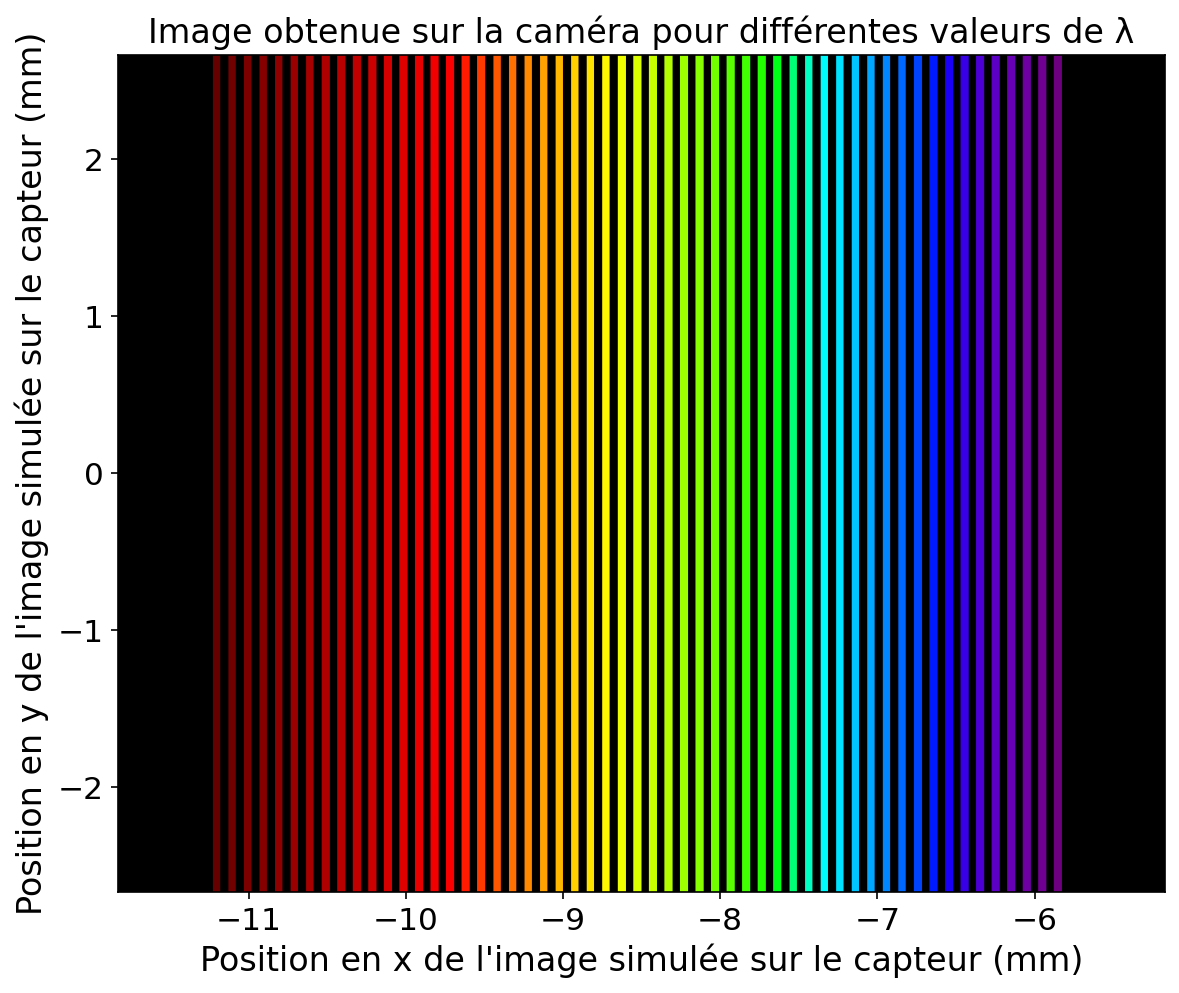

In [61]:
# Création d'une image RGB 
image_combined = np.zeros((nb_pixel_y, nb_pixel_x, 3), dtype=np.float32)

# Boucle sur chaque longueur d'onde
for lambda_input in lambda_values:
    U2_input = rect(Y, F_1/(b*F_2), 0) * rect(X, F_1/(a*F_2), lambda_input * F_2/(lambda_big))
    
    # Obtention des valeurs RGB pour la couleur de la bande
    R, G, B = wavelength_to_rgb(lambda_input * 1e6)  # (nm)

    image_rgb = np.zeros((nb_pixel_y, nb_pixel_x, 3), dtype=np.float32)
    image_rgb[..., 0] = R / 255 * U2_input 
    image_rgb[..., 1] = G / 255 * U2_input  
    image_rgb[..., 2] = B / 255 * U2_input  
    
    mask = U2_input > 0 
    image_combined[mask] = image_rgb[mask]

# Paramètres de la police pour l'affichage conforme aux normes IEEE
plt.rcParams.update({
    'font.size': 20,  # Taille de la police ajustée pour correspondre au texte IEEEtran
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18
})

# Affichage de l'image
plt.figure(figsize=(9, 9))
plt.imshow(image_combined, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
plt.title("Image obtenue sur la caméra pour différentes valeurs de λ")
plt.xlabel("Position en x de l'image simulée sur le capteur (mm)")
plt.ylabel("Position en y de l'image simulée sur le capteur (mm)")
plt.xticks(fontsize=15)  # Taille des graduations sur l'axe x
plt.yticks(fontsize=15)  # Taille des graduations sur l'axe y
plt.show()

On choisi alors une longueur focale de 25 mm pour $f_2$. On optimise la résolution du spectromètre $\lambda_2-\lambda_1=\frac{a\Lambda}{f_1}$. Puisque $f_1$ est inversement proportionnelle à la résolution, on choisi $f_1=50$ mm. 